# Customer Models on GCP - Using TF

In [232]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Reshape, Dot
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras import regularizers

import tensorflow.keras.metrics as metrics


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(location="US")

## Play with TF2 and Keras

Ref: 
* https://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommenderhttps://www.kaggle.com/code/morrisb/how-to-recommend-anything-deep-recommender
* https://nipunbatra.github.io/blog/ml/2017/12/18/recommend-keras.htmlhttps://nipunbatra.github.io/blog/ml/2017/12/18/recommend-keras.html



### Load data from BigQuery

In [3]:
sql_query = """
SELECT
  visitorId,
  contentId,
  0.3 * (1 + (session_duration - 57937) / 57937) AS rating
FROM bqml_recommender.analytics_session_data
WHERE 0.3 * (1 + (session_duration - 57937) / 57937) < 1
"""

df_raw = client.query(sql_query).to_dataframe()
df_raw.head()

,visitorId,contentId,rating
0,7337153711992174438,100074831,0.231210
1,2293633612703952721,100510126,0.247220
2,5874973374932455844,100510126,0.166262
3,1173698801255170595,100676857,0.054432
4,883397426232997550,10083328,0.945044


In [155]:
modelling_df = df_raw
# df = df_raw.iloc[0:100000, :]

train_df, test_df = train_test_split(modelling_df, test_size=0.2)

modelling_df.shape

(236181, 3)

In [214]:
len(user_id_mapping), len(item_id_mapping)

(72539, 4623)

In [157]:
# Create user- & movie-id mapping
user_id_mapping = {id: i for i, id in enumerate(modelling_df["visitorId"].unique())}
item_id_mapping = {id: i for i, id in enumerate(modelling_df["contentId"].unique())}


# Create correctly mapped train- & testset
train_user_data =  train_df["visitorId"].map(user_id_mapping)
train_item_data = train_df["contentId"].map(item_id_mapping)

test_user_data = test_df["visitorId"].map(user_id_mapping)
test_item_data = test_df["contentId"].map(item_id_mapping)


### Collaborative Filtering / Matrix Factorisation Using Keras

#### Model

In [300]:
user_num, item_num = len(user_id_mapping), len(item_id_mapping)
embedding_size = 10

# input layers
user_input = Input(shape=[1], name='user')
item_input = Input(shape=[1], name='item')

# embedding layers for users and items
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=user_num,
                           input_length=1, 
                           name='user_embedding')(user_input)
item_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=item_num,
                            input_length=1, 
                            name='item_embedding')(item_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
item_vector = Reshape([embedding_size])(item_embedding)

# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, item_vector])

# Setup model
model_mf = Model(inputs=[user_input, item_input], outputs=y)

model_mf.compile(
    optimizer="adam",
    loss="mse", 
)

model_mf.summary()

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        725390      ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        46230       ['item[0][0]']                   
                                                                                           

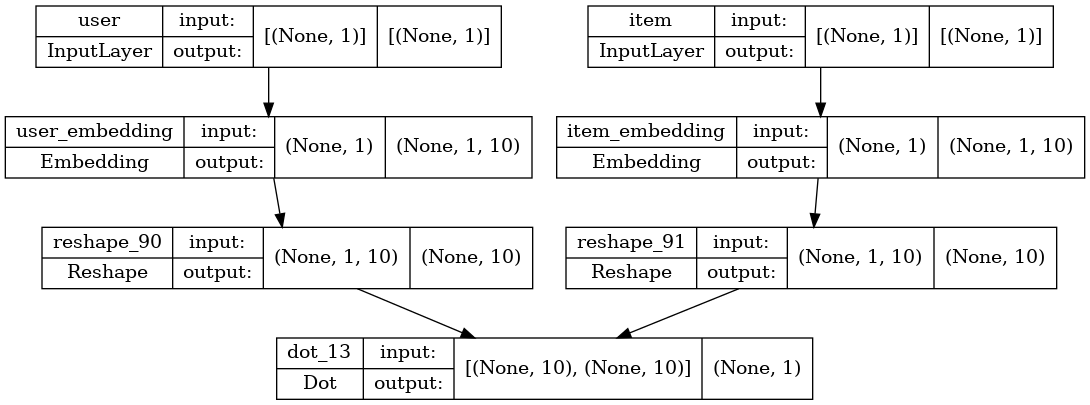

In [301]:
dot_img_file = '/tmp/model_mf.png'

tf.keras.utils.plot_model(model_mf, to_file=dot_img_file, show_shapes=True)


#### Train & Test

In [302]:
history = model_mf.fit(
    [train_user_data, train_item_data],
    train_df["rating"],
    batch_size=256, 
    epochs=10,
    validation_split=0.1,
    shuffle=True,
    verbose=-1,
)

# Test model
y_pred = model_mf.predict([test_user_data, test_item_data])
y_true = test_df["rating"].values

#  Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
print(f"Testing Result With Matrix-Factorization:\n RMSE: {rmse:.4f}, MAE: {mae:.4f} ")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Testing Result With Matrix-Factorization:
 RMSE: 0.3307, MAE: 0.2460 


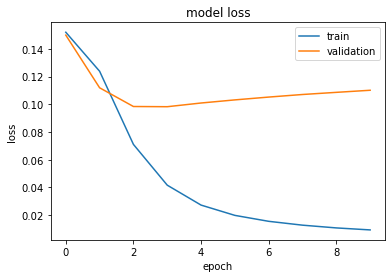

In [303]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper right')

### Deep Learning With Keras


#### Model

In [351]:
user_embedding_size = 6
item_embedding_size = 4

# input layers
user_input = Input(shape=[1], name='user')
item_input = Input(shape=[1], name='item')

# embedding layers for users and item
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=user_num,
                           input_length=1, 
                           name='user_embedding')(user_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                            input_dim=item_num,
                            input_length=1, 
                            name='item_embedding')(item_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
item_vector = Reshape([item_embedding_size])(item_embedding)

# Concatenate the reshaped embedding layers and drop out some
concat = Concatenate()([user_vector, item_vector])
concat_dropout = Dropout(0.2)(concat)

# Combine with dense layers
dense_1 = Dense(32, activation='relu')(concat_dropout)
dense_dropout_1 = Dropout(0.2)(dense_1)

dense_2 = Dense(8, activation='relu')(dense_dropout_1)
dense_dropout_2 = Dropout(0.2)(dense_2)

# dense_3 = Dense(4, activation='relu')(dense_dropout_2)
# dense_dropout_3 = Dropout(0.2)(dense_3)

y = Dense(1, 
          kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.001),
          )(dense_dropout_2)

# Setup model
model_eb = Model(inputs=[user_input, item_input], outputs=y)

model_eb.compile(
    optimizer="adam",
    loss="mse", 
#    metrics=[metrics.MeanSquaredError(), metrics.AUC()],
)

model_eb.summary()

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 6)         435234      ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 4)         18492       ['item[0][0]']                   
                                                                                           

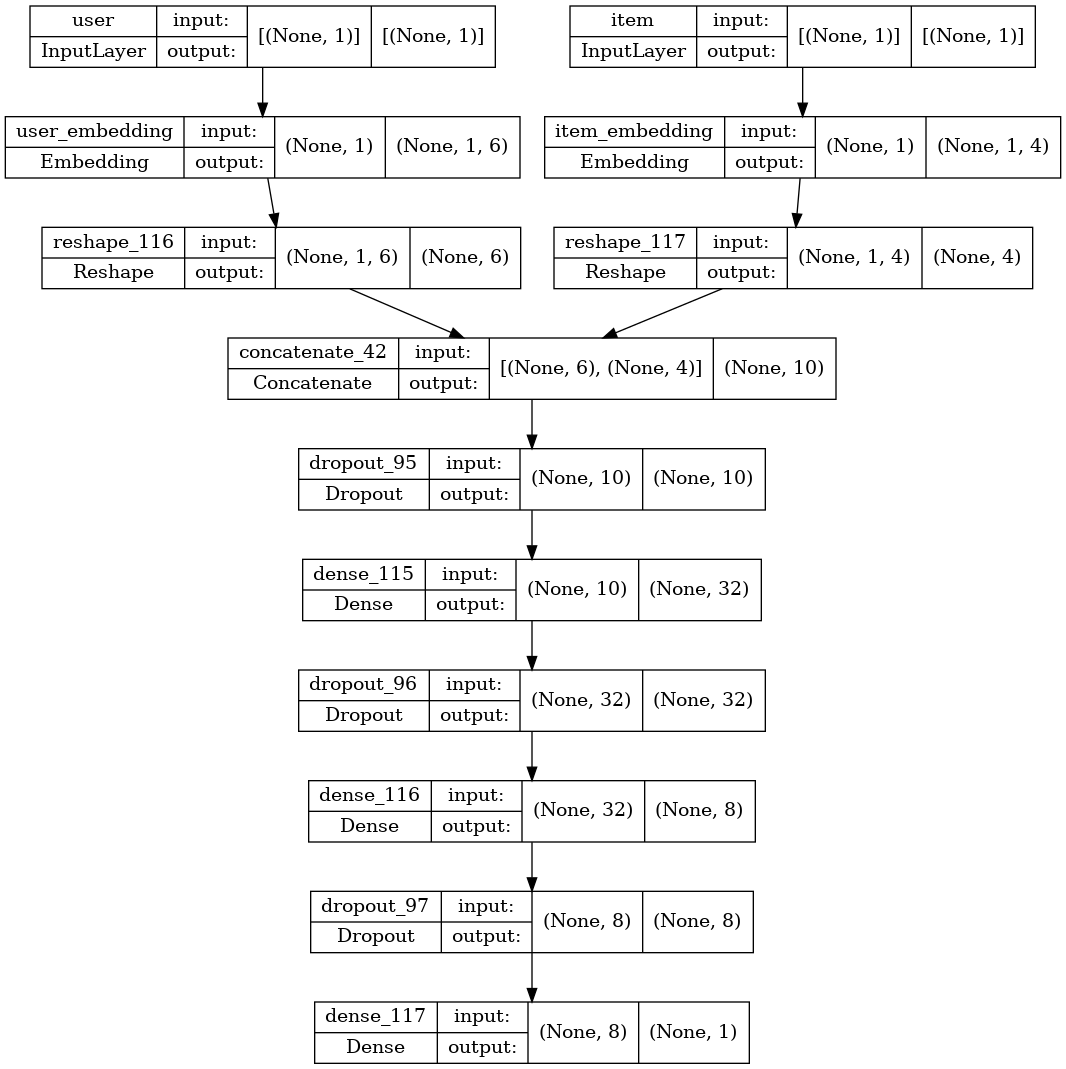

In [352]:
dot_img_file = '/tmp/model_eb.png'

tf.keras.utils.plot_model(model_eb, to_file=dot_img_file, show_shapes=True)

#### Train and Test

In [353]:

history = model_eb.fit(
    [train_user_data, train_item_data],
    train_df["rating"],
    batch_size=128, 
    epochs=5,
    validation_split=0.1,
    shuffle=True,
    verbose=-1,
)

# Test model
y_pred = model_eb.predict([test_user_data, test_item_data])
y_true = test_df["rating"].values

#  Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
print(f"Testing Result With Matrix-Factorization:\n RMSE: {rmse:.4f}, MAE: {mae:.4f} ")

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Testing Result With Matrix-Factorization:
 RMSE: 0.2477, MAE: 0.1948 


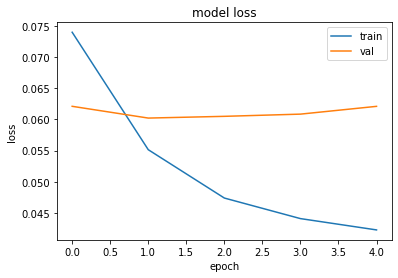

In [354]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

## Play with Tensorflow Recommenders

Ref:
* https://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.htmlhttps://blog.tensorflow.org/2020/09/introducing-tensorflow-recommenders.html
 * https://blog.tensorflow.org/2020/11/tensorflow-recommenders-scalable-retrieval-feature-interaction-modelling.htmlhttps://blog.tensorflow.org/2020/11/tensorflow-recommenders-scalable-retrieval-feature-interaction-modelling.html
 * https://www.tensorflow.org/recommenders/examples/basic_retrievalhttps://www.tensorflow.org/recommenders/examples/basic_retrieval

In [13]:
!pip install --user tensorflow_recommenders

  Using cached tensorflow_recommenders-0.6.0-py3-none-any.whl (85 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs


In [193]:
tf.__version__